In [1]:
# Cell 1: Import Libraries
import ee
import geemap
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates

2024-10-08 10:19:44.010938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 10:19:44.027134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 10:19:44.042837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 10:19:44.048263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 10:19:44.061613: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Cell 2: Initialize Google Earth Engine
def initialize_gee():
    """Authenticate and initialize Google Earth Engine."""
    ee.Authenticate()
    ee.Initialize(project='ee-geosynta')

# Initialize GEE
initialize_gee()

In [3]:
# Cell 3: Fetch Climate Data from Google Earth Engine
def fetch_gee_data(region_of_interest):
    """Retrieve datasets from Google Earth Engine for the specified region."""
    datasets = {
        'LST': ee.ImageCollection('MODIS/061/MOD11A2').select('LST_Day_1km'),
        'Precipitation': ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').select('precipitation'),
        'Humidity': ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").select(['Tair_f_inst', 'Psurf_f_inst', 'Qair_f_inst']),
        'SolarRadiation': ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").select('SWdown_f_tavg'),
        'SoilMoisture': ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").select('SoilMoi0_10cm_inst'),
        'WindSpeed': ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").select('Wind_f_inst'),
        'Evapotranspiration': ee.ImageCollection("MODIS/061/MOD16A2").select('ET'),
        'NDVI': ee.ImageCollection('MODIS/061/MOD13Q1').select('NDVI'),
        'CloudCover': ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY').select('probability'),
        'CO': ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO').select('CO_column_number_density')
    }
    
    # Filter by date and region
    for name, dataset in datasets.items():
        datasets[name] = dataset.filterDate('2015-01-01', '2023-01-01').filterBounds(region_of_interest)
    
    return datasets

# Define region of interest (Madhya Pradesh)
region_of_interest = ee.FeatureCollection("FAO/GAUL/2015/level1") \
                       .filter(ee.Filter.eq("ADM1_NAME", "Madhya Pradesh")) \
                       .geometry()

# Fetch datasets
datasets = fetch_gee_data(region_of_interest)

In [4]:
# Cell 4: Calculate Mean Values for Datasets
def calculate_means(datasets, region_of_interest):
    """Calculate mean values for the datasets."""
    
    # Relative Humidity Calculation
    def calculate_relative_humidity(T, p, q):
        """Calculate relative humidity using specific humidity, pressure, and temperature."""
        T0 = ee.Image(273.16)  # Reference temperature
        numerator = ee.Image(0.263).multiply(p).multiply(q)
        denominator = ee.Image.exp(ee.Image(17.67).multiply(T.subtract(T0)).divide(T.subtract(ee.Image(29.65))))
        return numerator.divide(denominator)
    
    # Process each dataset
    mean_datasets = {}
    for name, dataset in datasets.items():
        if name == 'Humidity':
            # Extract specific variables for humidity
            T = dataset.select('Tair_f_inst').mean()
            p = dataset.select('Psurf_f_inst').mean()
            q = dataset.select('Qair_f_inst').mean()
            # Calculate relative humidity
            relative_humidity = calculate_relative_humidity(T, p, q).clip(region_of_interest)
            mean_datasets['Relative_Humidity'] = relative_humidity
        else:
            # Calculate mean and clip the image for other datasets
            mean_datasets[name] = dataset.mean().clip(region_of_interest)
    
    return mean_datasets

mean_datasets = calculate_means(datasets, region_of_interest)

In [ ]:
# Cell 5: Export Data to Google Drive
def export_to_drive(image, description, region_of_interest):
    """Export the image to Google Drive."""
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        fileFormat='GeoTIFF',
        region=region_of_interest.bounds(),
        scale=1000
    )
    task.start()

# Export all processed datasets to Google Drive
for name, image in mean_datasets.items():
    export_to_drive(image, f'{name}_mean_export', region_of_interest)


In [ ]:
# Cell 6: Load Data from GeoTIFF files
geo_tiff_paths = {
    'LST': 'data/LST_mean_export.tif',
    'Precipitation': 'data/Precipitation_mean_export.tif',
    'Relative_Humidity': 'data/Relative_Humidity_mean_export.tif',
    'SolarRadiation': 'data/SolarRadiation_mean_export.tif',
    'SoilMoisture': 'data/SoilMoisture_mean_export.tif',
    'WindSpeed': 'data/WindSpeed_mean_export.tif',
    'Evapotranspiration': 'data/Evapotranspiration_mean_export.tif',
    'NDVI': 'data/NDVI_mean_export.tif',
    'CloudCover': 'data/CloudCover_mean_export.tif', 
    'CO': 'data/CO_mean_export.tif'
}

data_images = {}
for name, path in geo_tiff_paths.items():
    with rasterio.open(path) as src:
        image = src.read(1)
        image = np.where(image == src.nodata, np.nan, image)
        image = np.nan_to_num(image, nan=np.nanmean(image))
        data_images[name] = image

In [6]:
# Cell 7: Normalize and Prepare Data for LSTM
# Normalize the data
scalers = {}
scaled_data = {}
for name, image in data_images.items():
    scaler = MinMaxScaler()
    scaled_data[name] = scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)
    scalers[name] = scaler

# Create time-series data
def create_features(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Flatten the data
flattened_data = {name: image.flatten() for name, image in scaled_data.items()}

# Combine features for LSTM input (including all datasets)
combined_data = np.stack(
    (flattened_data['LST'], flattened_data['Precipitation'], flattened_data['Relative_Humidity'], 
     flattened_data['SolarRadiation'], flattened_data['SoilMoisture'], flattened_data['WindSpeed'],
     flattened_data['Evapotranspiration'], flattened_data['NDVI'], flattened_data['CloudCover'], 
     flattened_data['CO']), axis=1)

look_back = 10
X, y = create_features(combined_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Reshape for LSTM

In [7]:
# Cell 8: Split Data into Train and Validation Sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [8]:
# Cell 9: Build and Compile LSTM Model
def build_lstm_model(input_shape):
    """Build and compile the LSTM model."""
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=input_shape))
    model.add(Dense(10))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Build the model
model = build_lstm_model((look_back, X_train.shape[2]))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Cell 10: Train the Model
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=16):
    """Train the LSTM model."""
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    return history

# Train the model
history = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 5.8672e-04 - val_mse: 5.8672e-04
Epoch 2/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - loss: 7.1892e-04 - mse: 7.1892e-04 - val_loss: 5.6074e-04 - val_mse: 5.6074e-04
Epoch 3/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 111s 4ms/step - loss: 6.9934e-04 - mse: 6.9934e-04 - val_loss: 5.4457e-04 - val_mse: 5.4457e-04
Epoch 4/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step - loss: 6.9063e-04 - mse: 6.9063e-04 - val_loss: 5.3038e-04 - val_mse: 5.3038e-04
Epoch 5/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 113s 4ms/step - loss: 6.7365e-04 - mse: 6.7365e-04 - val_loss: 5.4910e-04 - val_mse: 5.4910e-04
Epoch 6/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 6.7057e-04 - mse: 6.7057e-04 - val_loss: 5.5281e-04 - val_mse: 5.5281e-04
Epoch 7/10
31589/31589 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step - loss: 6.6606e-04 - mse: 6.6606e-04 - val_loss: 5.4466e-04 - val_mse: 5.4466e-04
Epoch 8/10
31589/31589 ━━━━━

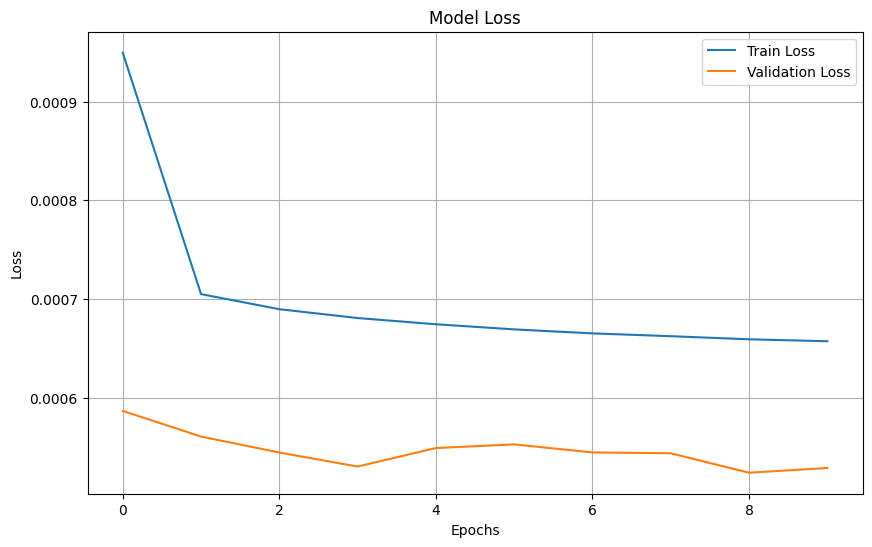

In [ ]:
# Cell 11: Plot training & validation loss values
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plot function after training
plot_loss(history)

# Save the model
model.save('output/climate_model.h5')

In [ ]:
from keras.models import load_model
from keras.losses import MeanSquaredError

# Define the custom objects
custom_objects = {'mse': MeanSquaredError()}

# Load the saved model
model = load_model('output/climate_model.h5', custom_objects=custom_objects)

# Predict using the trained model
predictions = model.predict(X)

19744/19744 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step


RMSE for each feature:
              Feature      RMSE
0                 LST  0.015251
1       Precipitation  0.010473
2   Relative_Humidity  0.020221
3      SolarRadiation  0.020271
4        SoilMoisture  0.035396
5           WindSpeed  0.018260
6  Evapotranspiration  0.040968
7                NDVI  0.030769
8          CloudCover  0.023888
9                  CO  0.017520


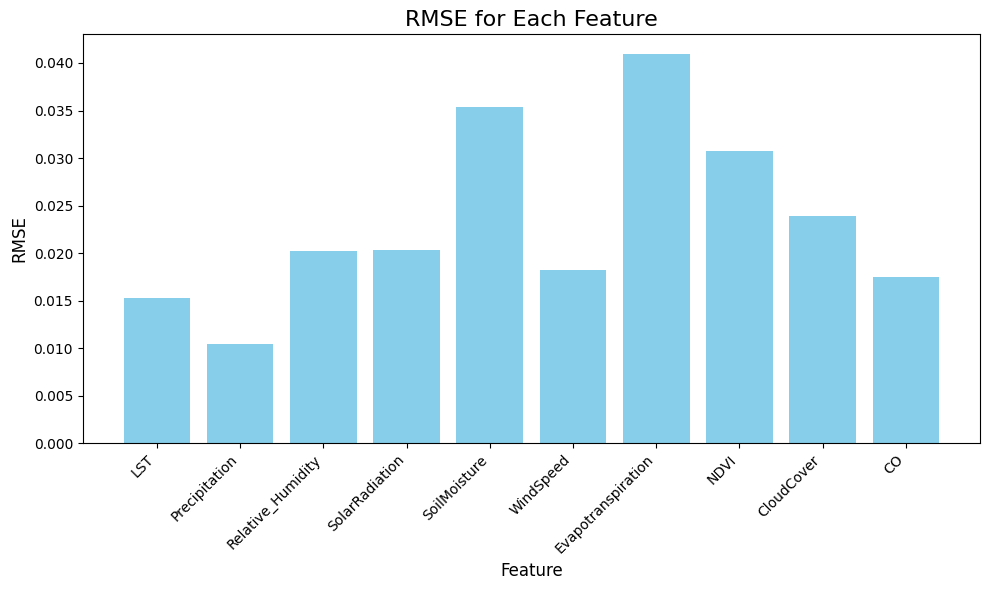

In [12]:
# Cell 13: Calculate evaluation metrics (e.g., RMSE for each feature)
rmse_scores = {}
for i, feature in enumerate(['LST', 'Precipitation', 'Relative_Humidity', 'SolarRadiation', 
                              'SoilMoisture', 'WindSpeed', 'Evapotranspiration', 
                              'NDVI', 'CloudCover', 'CO']):
    rmse_scores[feature] = np.sqrt(mean_squared_error(y[:, i], predictions[:, i]))

# Convert RMSE scores into a DataFrame for better visualization
rmse_df = pd.DataFrame(list(rmse_scores.items()), columns=['Feature', 'RMSE'])

# Print the RMSE values as a table
print("RMSE for each feature:")
print(rmse_df)

# Plot the RMSE values for each feature
plt.figure(figsize=(10, 6))
plt.bar(rmse_df['Feature'], rmse_df['RMSE'], color='skyblue')
plt.title('RMSE for Each Feature', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

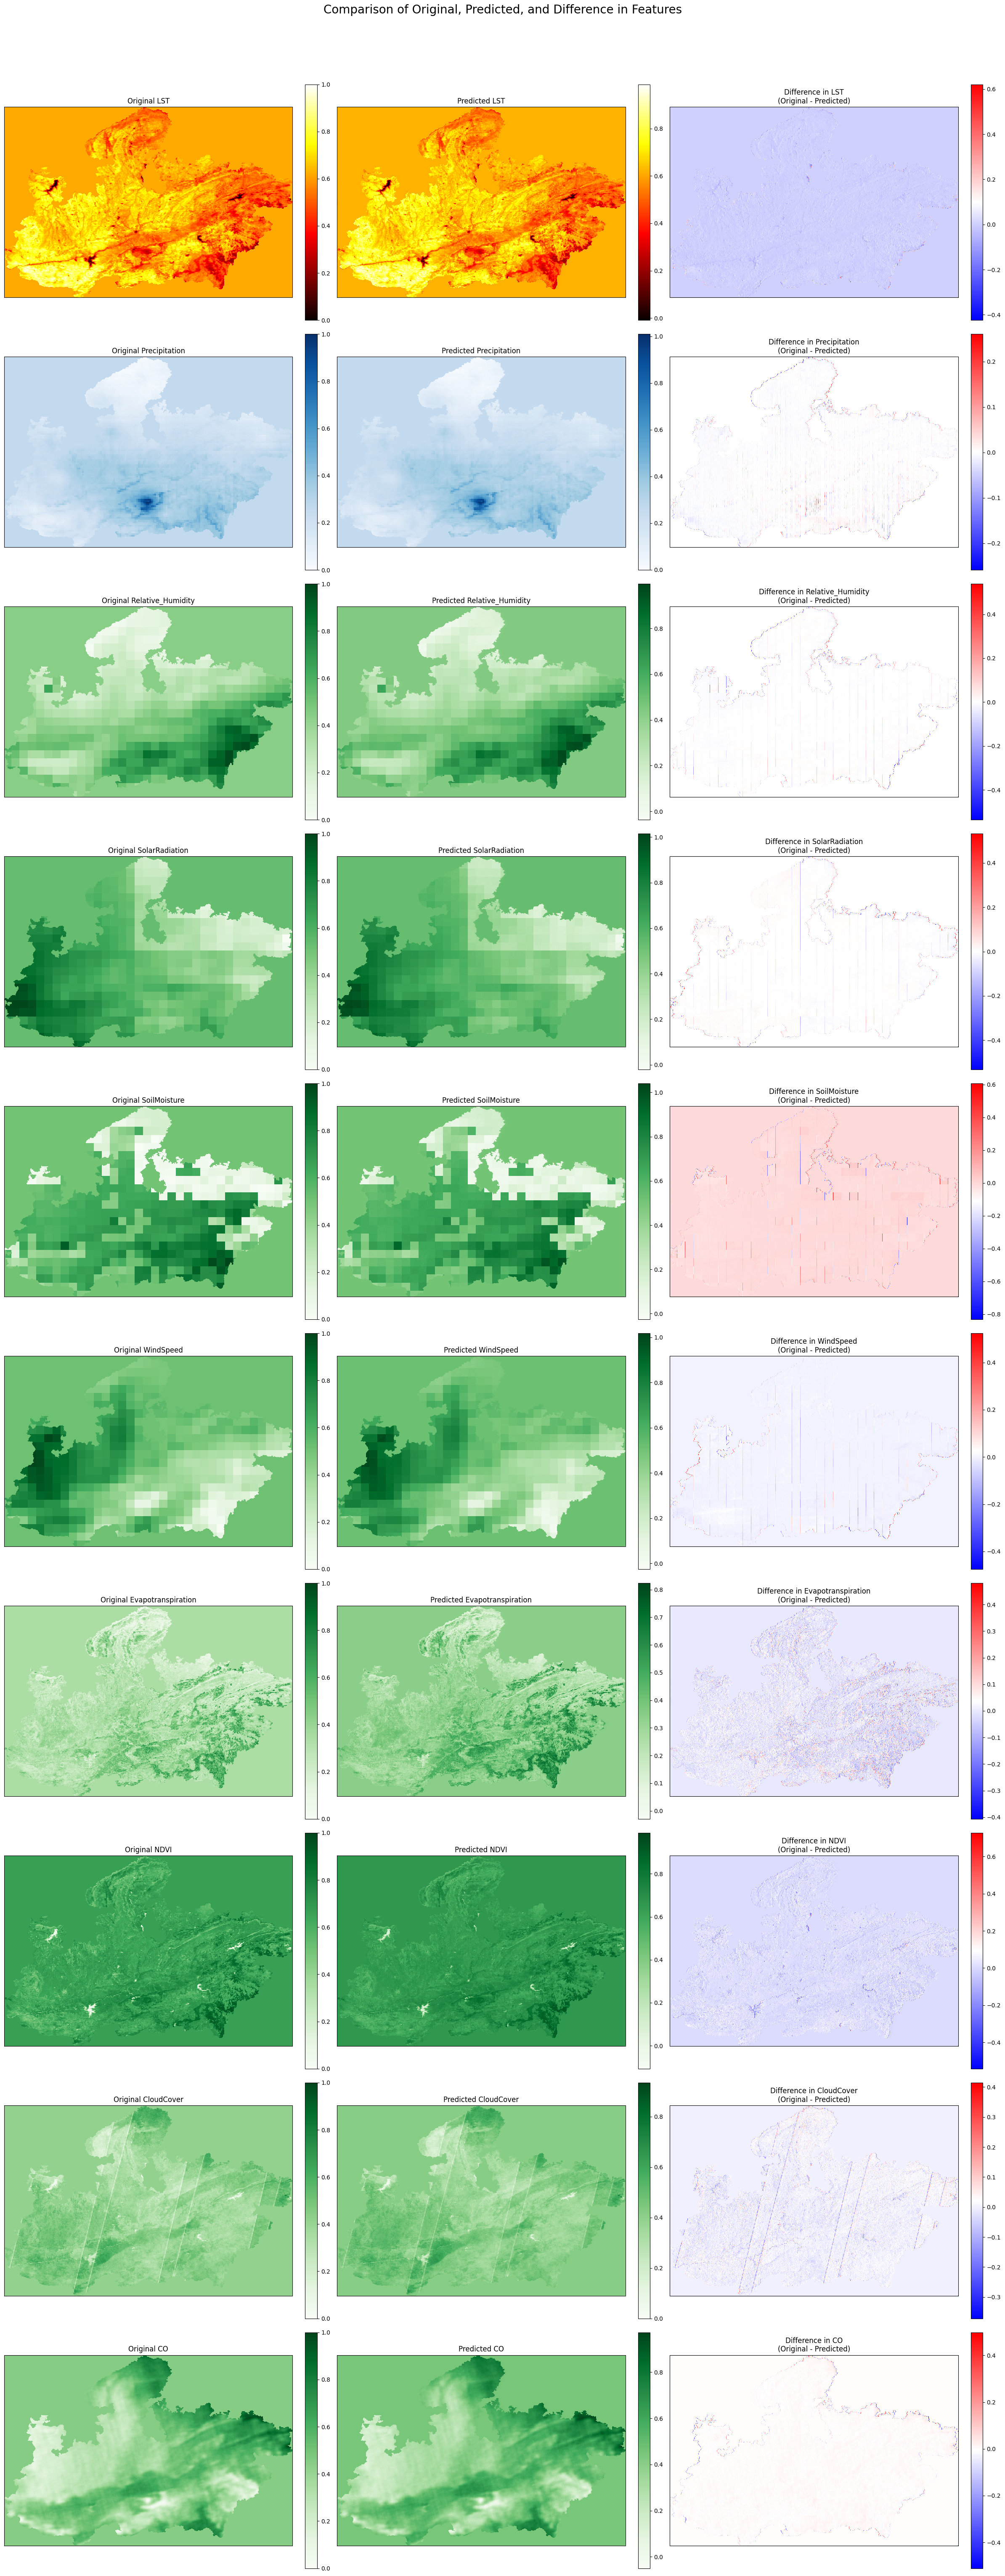

In [13]:
# Cell 14: Reshape and Plot Original, Predicted, and Difference Images
# Reshape predictions to match the available valid data points
valid_data_length = len(predictions)
predicted_images = {feature: np.zeros_like(flattened_data[feature]) for feature in flattened_data.keys()}

# Only place valid predictions into the reshaped arrays
for i, feature in enumerate(flattened_data.keys()):
    predicted_images[feature][look_back:look_back + valid_data_length] = predictions[:, i]

# Reshape the 1D arrays back into the original image shapes
for feature in predicted_images.keys():
    predicted_images[feature] = predicted_images[feature].reshape(scaled_data[feature].shape)

# Calculate the differences between the original and predicted values
diff_images = {feature: scaled_data[feature] - predicted_images[feature] for feature in scaled_data.keys()}

# Plot original, predicted, and difference images
def plot_features(scaled_data, predicted_images, diff_images):
    features = ['LST', 'Precipitation', 'Relative_Humidity', 'SolarRadiation', 
                'SoilMoisture', 'WindSpeed', 'Evapotranspiration', 
                'NDVI', 'CloudCover', 'CO']
    
    fig, axes = plt.subplots(len(features), 3, figsize=(24, 6*len(features)))
    fig.suptitle("Comparison of Original, Predicted, and Difference in Features", fontsize=20, y=1.02)

    for i, feature in enumerate(features):
        cmaps = {'LST': 'hot', 'Precipitation': 'Blues'}
        cmap = cmaps.get(feature, 'Greens')
        
        # Original data
        im = axes[i, 0].imshow(scaled_data[feature], cmap=cmap, interpolation='nearest')
        axes[i, 0].set_title(f'Original {feature}')
        fig.colorbar(im, ax=axes[i, 0], fraction=0.046, pad=0.04)

        # Predicted data
        im = axes[i, 1].imshow(predicted_images[feature], cmap=cmap, interpolation='nearest')
        axes[i, 1].set_title(f'Predicted {feature}')
        fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)

        # Difference
        im = axes[i, 2].imshow(diff_images[feature], cmap='bwr', interpolation='nearest')
        axes[i, 2].set_title(f'Difference in {feature}\n(Original - Predicted)')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        # Remove ticks for cleaner look
        for ax in axes[i]:
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_features(scaled_data, predicted_images, diff_images)

In [27]:
# Cell 15: Predict Future Climate Data
def predict_future(model, X_val, n_days, look_back):
    """Predict future climate data for the given number of days."""
    future_predictions = []
    input_sequence = X_val[-1:]  # Start with the last input sequence

    for _ in range(n_days):
        next_prediction = model.predict(input_sequence)  # Predict the next step
        future_predictions.append(next_prediction)  # Append prediction to results
        
        # Prepare the new input sequence for the next prediction
        input_sequence = np.append(input_sequence[:, 1:, :], np.expand_dims(next_prediction, axis=1), axis=1)

    return np.array(future_predictions).reshape(-1, next_prediction.shape[-1])


# Predict short-term (30 days) and long-term (365 days)
short_term_predictions = predict_future(model, X_val, 30, look_back)
long_term_predictions = predict_future(model, X_val, 365, look_back)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

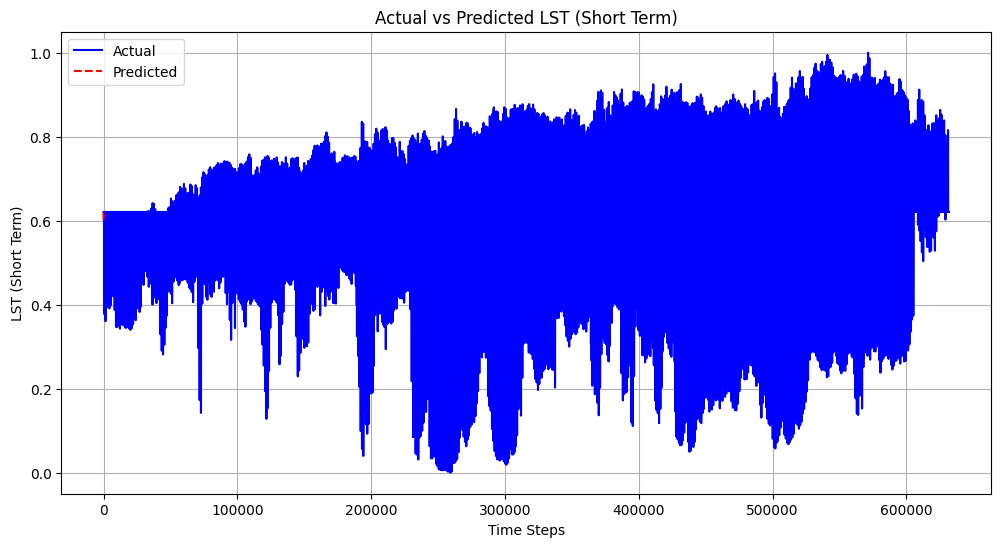

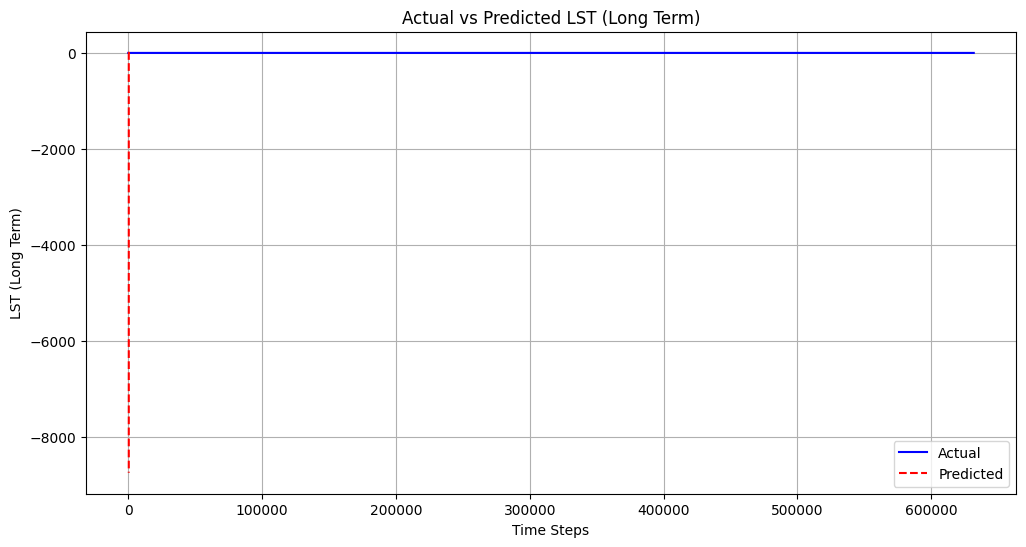

In [28]:
def plot_predictions(actual_data, predicted_data, feature_name):
    """Plot actual vs predicted values for a given feature."""
    plt.figure(figsize=(12, 6))
    plt.plot(actual_data, label='Actual', color='blue')
    plt.plot(predicted_data, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {feature_name}')
    plt.xlabel('Time Steps')
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid()
    plt.show()

# Example: Visualize predictions for a specific feature (e.g., LST)
plot_predictions(flattened_data['LST'][look_back:], short_term_predictions[:, 0], 'LST (Short Term)')
plot_predictions(flattened_data['LST'][look_back:], long_term_predictions[:, 0], 'LST (Long Term)')


In [16]:
# SPEI Calculation: Standardized Precipitation-Evapotranspiration Index
def calculate_spei(precip_image, evapotranspiration_image):
    """Calculate SPEI using precipitation and evapotranspiration."""
    spei = (precip_image - evapotranspiration_image) / np.std(precip_image - evapotranspiration_image)
    return spei

# Apply SPEI calculation
spei_image = calculate_spei(flattened_data['Precipitation'], flattened_data['Evapotranspiration'])

In [17]:
# PDSI Calculation: Palmer Drought Severity Index
def calculate_pdsi(precip_image, temp_image):
    """Calculate PDSI using precipitation and temperature data."""
    water_balance = precip_image - temp_image  # Simplified water balance model
    z = water_balance - np.mean(water_balance)  # Departure of moisture from normal
    pdsi = z + water_balance  # Sum of departure and water balance
    return pdsi

# Apply PDSI calculation
pdsi_image = calculate_pdsi(flattened_data['Precipitation'], flattened_data['Evapotranspiration'])

In [18]:
# SPI Calculation: Standardized Precipitation Index
def calculate_spi(precip_image):
    """Calculate SPI using precipitation data."""
    spi = (precip_image - np.mean(precip_image)) / np.std(precip_image)
    return spi

# Apply SPI calculation
spi_image = calculate_spi(flattened_data['Precipitation'])

In [19]:
# THI Calculation: Temperature-Humidity Index
def calculate_thi(temp_image, humidity_image):
    """Calculate THI using temperature and humidity data."""
    thi = temp_image - 0.55 * (1 - humidity_image) * (temp_image - 14.5)
    return thi

# Apply THI calculation
thi_image = calculate_thi(flattened_data['LST'], flattened_data['Relative_Humidity'])

In [ ]:
# CEI Calculation: Climate Extremes Index
def calculate_cei(extreme_data, total_area):
    """Calculate CEI as the proportion of extreme area to total area."""
    extreme_area = np.count_nonzero(extreme_data)  # Area with extreme conditions
    cei = (extreme_area / total_area) * 100
    return cei

# Calculate total area (assuming data is in grid format, e.g., 1000 x 1000 grid)
total_area = np.prod(flattened_data['LST'].shape)  # Example grid size
extreme_conditions = np.where(flattened_data['LST'] > 0.9, 1, 0)  # Example extreme condition (hot temperature)
cei_value = calculate_cei(extreme_conditions, total_area)

In [21]:
# CCII Calculation: Composite Climatic Change Intensity Index
def calculate_ccii(*args):
    """Calculate CCII using multiple normalized factors."""
    factors = np.stack(args, axis=-1)
    weights = np.ones(factors.shape[-1]) / factors.shape[-1]  # Equal weights for simplicity
    ccii = np.dot(factors, weights)
    return ccii

# Apply CCII calculation (combine multiple factors)
ccii_image = calculate_ccii(flattened_data['LST'], flattened_data['Precipitation'], flattened_data['Relative_Humidity'], flattened_data['SolarRadiation'], 
                            flattened_data['SoilMoisture'], flattened_data['WindSpeed'], flattened_data['Evapotranspiration'])

In [ ]:
# Cell 16: Visualize Predictions and Indices
def visualize_climate_indices(dates, real_data, future_data, index_name):
    """
    Visualize a climate index with real and predicted data.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot real data (solid line)
    plt.plot(dates[:len(real_data)], real_data, label=f'Real {index_name}', color='blue', linestyle='-')
    
    # Plot future data (dotted line)
    plt.plot(dates[len(real_data):], future_data, label=f'Predicted {index_name}', color='orange', linestyle='--')
    
    # Formatting the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    
    # Rotate and align x-axis labels
    plt.gcf().autofmt_xdate()

    plt.title(f'{index_name} from Historical Data to Future Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{index_name} Value')
    plt.grid(True)
    plt.legend()
    plt.show()

# Generate a list of dates from the starting date to the prediction period
start_date = pd.Timestamp('2015-01-01')
historical_dates = pd.date_range(start=start_date, periods=len(real_data), freq='M')  # Monthly data for real
future_dates = pd.date_range(start=historical_dates[-1] + pd.DateOffset(months=1), periods=len(future_data), freq='M')  # Monthly data for prediction
all_dates = historical_dates.append(future_dates)

# Example: Visualize SPEI, PDSI, SPI, THI, CEI, and CCII
visualize_climate_indices(all_dates, spei_image.flatten(), short_term_predictions, 'SPEI')
visualize_climate_indices(all_dates, pdsi_image.flatten(), short_term_predictions, 'PDSI')
visualize_climate_indices(all_dates, spi_image.flatten(), short_term_predictions, 'SPI')
visualize_climate_indices(all_dates, thi_image.flatten(), short_term_predictions, 'THI')
visualize_climate_indices(all_dates, np.array([cei_value]*len(real_data)), np.array([cei_value]*len(future_data)), 'CEI')
visualize_climate_indices(all_dates, ccii_image.flatten(), short_term_predictions, 'CCII')


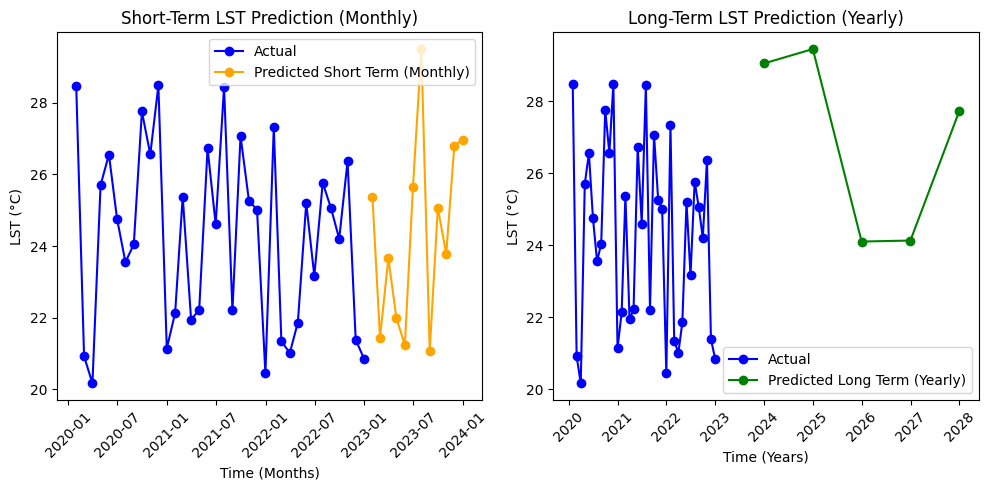

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data (you should replace these with your actual data)
# Assuming 'dates' is in a pandas datetime format
dates = pd.date_range(start="2020-01-01", periods=36, freq='M')  # 3 years of monthly data
actual_lst = np.random.rand(36) * 10 + 20  # Random historical LST values
predicted_lst_short_term = np.random.rand(12) * 10 + 20  # 1 year of monthly short-term prediction
predicted_lst_long_term = np.random.rand(5) * 10 + 20  # 5 years of yearly long-term prediction

# Generate future dates for predictions
future_dates_short_term = pd.date_range(start=dates[-1] + pd.DateOffset(months=1), periods=12, freq='M')
future_dates_long_term = pd.date_range(start=dates[-1] + pd.DateOffset(years=1), periods=5, freq='Y')

# Plotting the short-term prediction (Monthly)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(dates, actual_lst, label="Actual", color='blue', marker='o')
plt.plot(future_dates_short_term, predicted_lst_short_term, label="Predicted Short Term (Monthly)", color='orange', marker='o')
plt.xlabel('Time (Months)')
plt.ylabel('LST (°C)')
plt.title('Short-Term LST Prediction (Monthly)')
plt.xticks(rotation=45)
plt.legend()

# Plotting the long-term prediction (Yearly)
plt.subplot(1, 2, 2)
plt.plot(dates, actual_lst, label="Actual", color='blue', marker='o')
plt.plot(future_dates_long_term, predicted_lst_long_term, label="Predicted Long Term (Yearly)", color='green', marker='o')
plt.xlabel('Time (Years)')
plt.ylabel('LST (°C)')
plt.title('Long-Term LST Prediction (Yearly)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
